# Feedforward Neural Network Regression for Depth Thermography

In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import random
%matplotlib inline

In [66]:
# Parameters for Neural Network
args = {'lr':0.01,
        'train epochs':5000,
        'noise':0.01,
        'train size':0.8,
        'train criterion':nn.L1Loss(),
        'test criterion':nn.L1Loss(),
        'scaler':RobustScaler()
        }

## Data Prepocessing

In [67]:
# read data
df = pd.read_excel('GaN_data.xlsx')

In [68]:
df

,layer 1,layer 2,layer 3,layer 4,layer 5,layer 6,layer 7,layer 8,layer 9,layer 10,...,1.491e-05,1.492e-05,1.493e-05,1.494e-05,1.495e-05,1.496e-05,1.497e-05,1.498e-05,1.499e-05,1.5e-05
0,281.443585,297.802963,312.511424,329.035659,324.676947,324.755597,311.665007,305.758102,304.930994,312.888145,...,3.216321e-13,3.202331e-13,3.188511e-13,3.174857e-13,3.161367e-13,3.148039e-13,3.134870e-13,3.121858e-13,3.109001e-13,3.096295e-13
1,296.991615,291.238096,297.087249,293.282015,308.869958,324.087546,329.105778,330.545489,336.306789,336.253544,...,3.135249e-13,3.122424e-13,3.109757e-13,3.097246e-13,3.084888e-13,3.072681e-13,3.060623e-13,3.048711e-13,3.036944e-13,3.025318e-13
2,367.205059,355.446458,328.359064,316.581223,313.882413,302.686310,302.351195,301.035398,306.954536,305.165103,...,3.467919e-13,3.453366e-13,3.438987e-13,3.424780e-13,3.410741e-13,3.396870e-13,3.383162e-13,3.369615e-13,3.356228e-13,3.342998e-13
3,309.848460,332.144353,328.696847,336.841408,334.064870,327.177493,334.490652,322.029922,316.685842,317.165441,...,5.813533e-13,5.791552e-13,5.769823e-13,5.748344e-13,5.727111e-13,5.706120e-13,5.685367e-13,5.664850e-13,5.644565e-13,5.624509e-13
4,360.594281,341.285808,329.867225,318.373295,316.788635,308.948897,314.094178,313.834618,312.328127,306.323821,...,6.038114e-13,6.015425e-13,5.992991e-13,5.970809e-13,5.948876e-13,5.927188e-13,5.905741e-13,5.884534e-13,5.863561e-13,5.842820e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,309.086038,303.282495,300.923904,298.811984,301.558612,303.538408,314.901573,310.554347,320.360201,327.043901,...,3.214117e-13,3.200418e-13,3.186882e-13,3.173506e-13,3.160289e-13,3.147227e-13,3.134319e-13,3.121562e-13,3.108953e-13,3.096491e-13
1996,339.678328,323.625125,324.235328,313.762848,325.074688,325.750594,315.515256,322.098048,323.525065,324.956787,...,3.859106e-13,3.843254e-13,3.827591e-13,3.812114e-13,3.796820e-13,3.781707e-13,3.766770e-13,3.752009e-13,3.737420e-13,3.723000e-13
1997,280.595912,304.514047,324.918632,337.893330,336.515489,349.325408,349.914048,340.875595,337.944454,345.038485,...,6.229253e-13,6.205519e-13,6.182054e-13,6.158854e-13,6.135916e-13,6.113234e-13,6.090807e-13,6.068629e-13,6.046699e-13,6.025012e-13
1998,359.616451,309.836911,310.282320,307.928224,320.881583,323.548557,327.936862,339.748417,333.751675,335.678906,...,4.617652e-13,4.600576e-13,4.583703e-13,4.567029e-13,4.550552e-13,4.534268e-13,4.518175e-13,4.502269e-13,4.486549e-13,4.471012e-13


In [69]:
# layer data
y = df.filter(regex='layer')

# spectrum data
X = df.iloc[:,len(y.columns):]

In [72]:
# function to add noise as a percentage 
def add_noise(data, percentage):
    std_dev = percentage * data.std().sum()/len(data)
    noise = np.random.normal(0, std_dev, data.shape)
    noisy_data = data + noise
    return noisy_data

In [73]:
# add noise
X_noisy = add_noise(X, args['noise'])

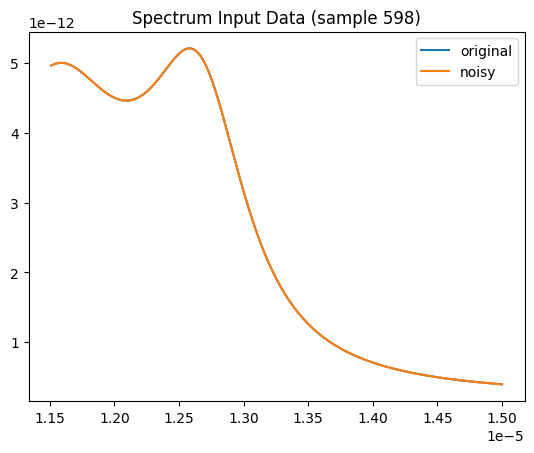

In [74]:
# plot the difference between noisy and original data
entry = random.randint(0, len(X))
plt.title(f'Spectrum Input Data (sample {entry})')
plt.plot(X.iloc[entry][-int(len(X.iloc[entry])*.5):], label='original')
plt.plot(X_noisy.iloc[entry][-int(len(X.iloc[entry])*.5):], label='noisy')
plt.legend()
plt.show()

In [75]:
# scale the input data
scaler = args['scaler']
X_noisy_scaled = scaler.fit_transform(X_noisy)

X_noisy_scaled_df = pd.DataFrame(X_noisy_scaled, columns=X.columns)

In [76]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_noisy_scaled_df, y, train_size=args['train size'])

In [77]:
# convert data to tensors for model
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

## Neural Network Setup

In [78]:
# define neural network
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.lin_input = nn.Linear(input_size, 30)
        self.hidden1 = nn.Linear(30, 15)
        self.lin_output = nn.Linear(15, output_size)

    def forward(self, x):
        x = F.relu(self.lin_input(x))
        x = F.relu(self.hidden1(x))
        x = self.lin_output(x)
        return x

In [79]:
# define loss function
criterion = args['train criterion']

# instantiate model
model = Net(X_train_tensor.size()[1], y_train_tensor.size()[1])

# define optimizer
optimizer = torch.optim.Rprop(model.parameters(), lr=args['lr'])

print(model)

Net(
  (lin_input): Linear(in_features=701, out_features=30, bias=True)
  (hidden1): Linear(in_features=30, out_features=15, bias=True)
  (lin_output): Linear(in_features=15, out_features=20, bias=True)
)


## Neural Network Training Loop

In [80]:
best_loss = np.inf
best_epoch = 0
train_losses = []
valid_losses = []

print('epoch'.ljust(6) + 
      '| train loss'.ljust(14) + 
      '| valid loss' + 
      '\n------|-------------|------------')

for epoch in range(args['train epochs']):
    # forward pass
    outputs = model(X_train_tensor)

    # get loss
    loss = criterion(outputs, y_train_tensor)

    # update and backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # add losses to the list for tracking
    train_losses.append(loss.item())
    
    # check if it is the best loss
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_epoch = epoch+1

    # get validation loss
    valid_pred = model(X_test_tensor)
    valid_loss = criterion(valid_pred, y_test_tensor)
    valid_losses.append(valid_loss.item())

    if (epoch+1) % int(args['train epochs']/10) == 0:
        print(f'{epoch+1}'.ljust(6) + 
              f'|   {loss:.4f}'.ljust(14) + 
              f'|   {valid_loss.item():.4f}')

print(f'\nbest training loss: {best_loss:.3f} in epoch {best_epoch}\n')  

epoch | train loss  | valid loss
------|-------------|------------
1000  |   4.4062    |   4.5126
2000  |   4.2923    |   4.4039
3000  |   3.9350    |   4.0256
4000  |   3.7457    |   3.8320
5000  |   3.7319    |   3.8194
6000  |   3.7293    |   3.8168
7000  |   3.7270    |   3.8140
8000  |   3.7255    |   3.8118
9000  |   3.7244    |   3.8102
10000 |   3.7236    |   3.8091

best training loss: 3.724 in epoch 9999



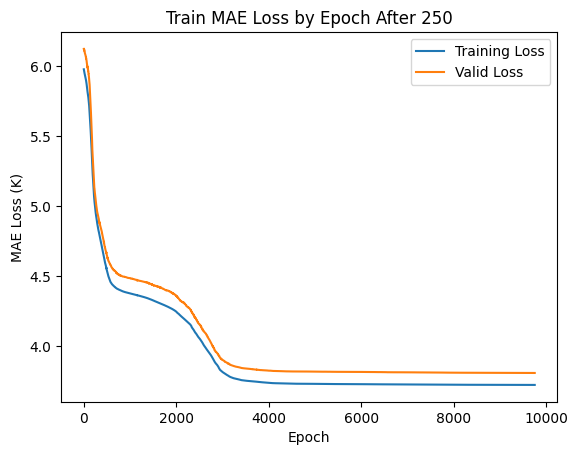

In [81]:
# plot loss over epochs
plt.plot(train_losses[250:], label='Training Loss')
plt.plot(valid_losses[250:], label='Valid Loss')

    
plt.title("Train MAE Loss by Epoch After 250")
plt.xlabel("Epoch")
plt.ylabel("MAE Loss (K)")
plt.legend()
plt.show()

## Model Testing

In [82]:
# test model on validation data
test_criterion = args['test criterion']
test_losses = []
overall_loss = 0

print('Test Losses')
with torch.no_grad():
    model.eval()

    # overall predictions and loss
    pred = model(X_test_tensor)
    loss = test_criterion(pred, y_test_tensor)

    overall_loss = loss.item()
    
    print(f'Overall: {loss.item()}\n')

    # per layer loss based on previous predictions
    pred_layers = []
    for i in range(pred.size(1)):
        column = pred[:, i]
        pred_layers.append(column)

    actual_layers = []
    for i in range(y_test_tensor.size(1)):
        column = y_test_tensor[:, i]
        actual_layers.append(column)

    for i in range(y_test_tensor.size(1)):
        loss = test_criterion(pred_layers[i], actual_layers[i])
        test_losses.append(loss.item())
        print(f'Layer {i+1}: {loss.item()}')

#print(test_losses)

Test Losses
Overall: 3.8090615272521973

Layer 1: 13.519420623779297
Layer 2: 5.825455188751221
Layer 3: 2.9681661128997803
Layer 4: 2.7800323963165283
Layer 5: 1.2731553316116333
Layer 6: 4.188129425048828
Layer 7: 3.801919937133789
Layer 8: 3.4060263633728027
Layer 9: 3.303415536880493
Layer 10: 1.3413604497909546
Layer 11: 4.802227020263672
Layer 12: 4.998165130615234
Layer 13: 4.028541088104248
Layer 14: 3.7113895416259766
Layer 15: 3.0056111812591553
Layer 16: 3.499220609664917
Layer 17: 2.7797513008117676
Layer 18: 2.9005539417266846
Layer 19: 2.9151368141174316
Layer 20: 1.1335570812225342


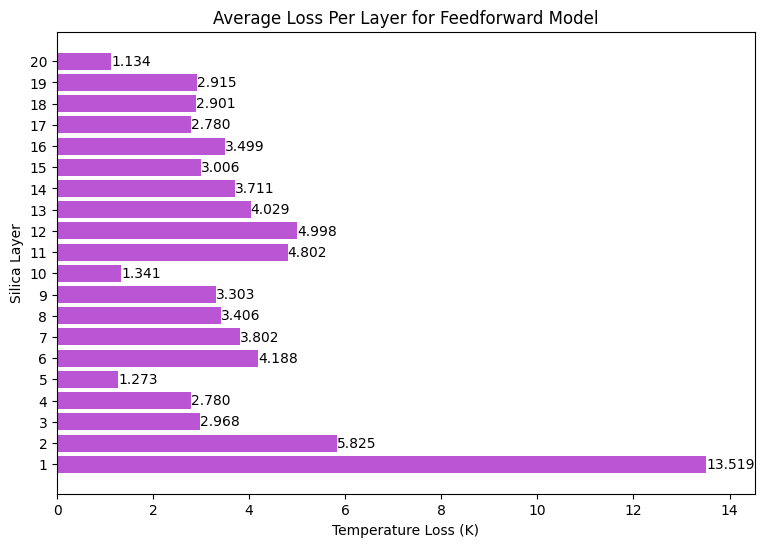

In [83]:
# plot losses
plt.figure(figsize=(9,6))
plt.title('Average Loss Per Layer for Feedforward Model')
plt.barh(range(1,len(y.columns)+1), test_losses, color='mediumorchid')
plt.yticks(range(1,len(y.columns)+1))
plt.xlabel("Temperature Loss (K)")
plt.ylabel("Silica Layer")
plt.xlim(0,max(test_losses)+1)

for i, loss in enumerate(test_losses):
    plt.text(loss, i + 1, f'{loss:.3f}', ha='left', va='center')

plt.show()

## Prediction Visualization

In [84]:
# put predictions into dataframe for comparison
pred_df = pd.DataFrame(pred.numpy())

In [85]:
# function to plot comparison between predicted and actual values from a given sample
def plot_comparison(pred, actual, sample):
    plt.figure(figsize=(12, 6))
    plt.title(f"Feedforward Temperature Predictions for Sample {sample}", fontsize=20)
    plt.xlabel("Silica Layer", fontsize=18)
    plt.ylabel("Temperature (K)", fontsize=18)
    plt.plot([i+1 for i in range(11)], actual, color='darkgray', marker='s', label='actual')
    plt.plot([i+1 for i in range(11)], pred, color='mediumorchid', marker='o', linestyle=' ', label='predicted')
    plt.xticks(range(1,len(y.columns)+1), fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim(285, 350)
    
    #for i in range(len(pred)):
    #    diff = abs(pred[i] - actual[i])
    #    plt.text(i+1, pred[i] + 2, f"{diff:.2f}", fontsize=16, horizontalalignment='center', verticalalignment='center')
        
    plt.legend()
    plt.show()

ValueError: x and y must have same first dimension, but have shapes (11,) and (20,)

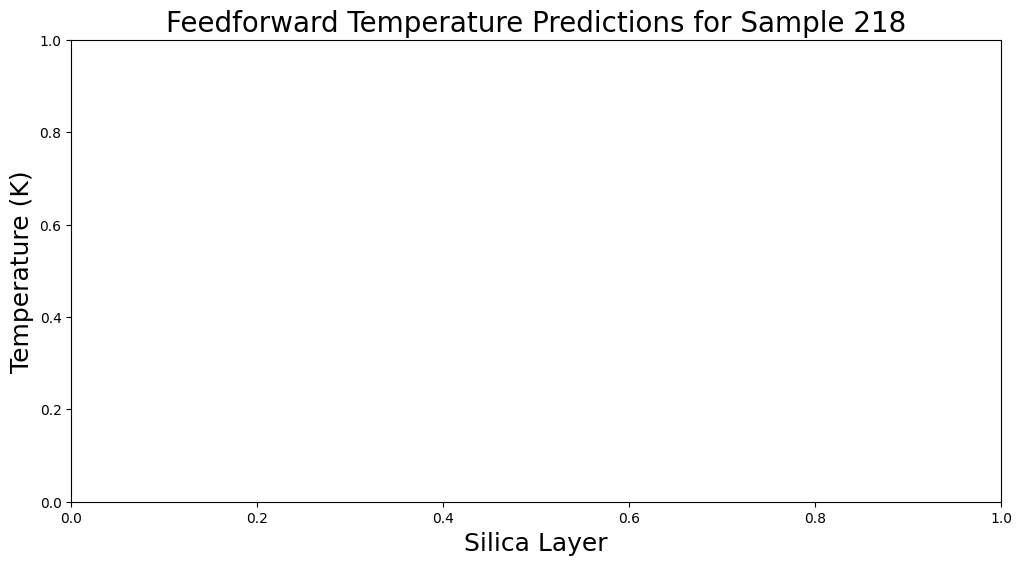

In [86]:
# pick 5 random indices from the dataset and plot the comparison between predicted and actual values
indices = []
for i in range(0,5):
    n = random.randint(0, len(y_test))
    indices.append(n)

for i in indices:
    a = y_test.iloc[i,:]
    p = pred_df.iloc[i,:]

    plot_comparison(p, a, i)

In [ ]:
loss_dif = np.inf
closest = 0
closest_loss = 0

for i in range(len(X_test)):
    x_row = X_test_tensor[i]
    y_row = y_test_tensor[i]

    pred = model(x_row)
    loss = test_criterion(pred, y_row)

    dif = abs(loss.item() - 3.534)
    if dif < loss_dif:
        loss_dif = dif
        closest = i
        closest_loss = loss.item()

print(closest_loss)


3.524183750152588


ValueError: x and y must have same first dimension, but have shapes (11,) and (20,)

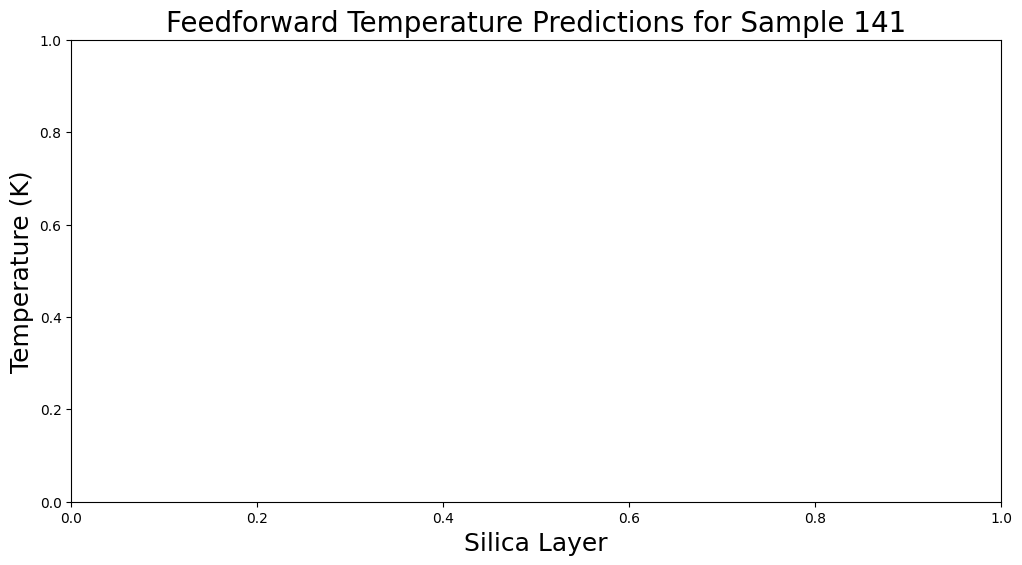

In [ ]:
a = y_test.iloc[closest,:]
p = pred_df.iloc[closest,:]

plot_comparison(p, a, closest)

In [ ]:
'''with open('simple_net_results.txt', 'a') as file:
    file.write(f'{overall_loss}\n')
    file.write(f'{test_losses}\n\n')'''

"with open('simple_net_results.txt', 'a') as file:\n    file.write(f'{overall_loss}\n')\n    file.write(f'{test_losses}\n\n')"